<a href="https://colab.research.google.com/github/dorienh/computational_data_science/blob/master/lab10b%20-%20word2vec%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification with word2vec 

-- Prof. Dorien Herremans

We will be tackling a classification problem by first creating word embeddings, and comparing this to alternative approaches. 

During this tutorial, you will need some of the following libraries: 

In [0]:
# !pip install bs4 
# !pip install sklearn
# !pip install nltk
# !pip install gensim
# !pip install lxml

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

## Preparing the dataset

The classification problem at hand is to predict the tag that belongs to a stack overflow post. 

The data from Google BigQuery is publicly available at this Cloud Storage URL:

https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

Like before, I first load my dataset from my private dropbox to Google Colab. Those of you working on your own machines, no need for this step. Skip to the next one. 


In [19]:
# !pip install dropbox
import dropbox
access_token = 'your_token_get_at' # https://www.dropbox.com/developers/apps
dbx = dropbox.Dropbox(access_token)

j = "/path_within_your_dropbox/stack-overflow-data.csv"
dbx.files_download_to_file('/stack-overflow-data.csv', j)

FileMetadata(name='stack-overflow-data.csv', id='id:F3kUIwrgEV8AAAAAAAtYjg', client_modified=datetime.datetime(2018, 10, 17, 9, 0, 11), server_modified=datetime.datetime(2018, 10, 22, 10, 7, 19), rev='6fbcab5bbb0', size=44319561, path_lower='/cds/week 10 - word2vec/lab/data/stack-overflow-data.csv', path_display='/CDS/week 10 - word2vec/lab/data/stack-overflow-data.csv', parent_shared_folder_id='3400907696', media_info=None, symlink_info=None, sharing_info=FileSharingInfo(read_only=False, parent_shared_folder_id='3400907696', modified_by='dbid:AACoui9q33n9Ww_K5AZehsrUdiK8zsU0_1E'), property_groups=None, has_explicit_shared_members=None, content_hash='c482a2aa50f49ec41b402f8efc522bd35f5f97f575318f91c1fc142573019f62')

Let's start by having a look at our data: 

In [20]:
!mv /stack-overflow-data.csv /data
df = pd.read_csv('data/stack-overflow-data.csv', encoding = 'latin-1')

# only keep data that has a tag: 
df = df[pd.notnull(df['tags'])]
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


The size of our model will depend on how many unqiue words are in the dataset (meaning in the article text or posts): 

In [21]:
# Count the number of words: 
df['post'].apply(lambda x: len(x.split(' '))).sum()

10286120

We have over 10 million words in the data. That's a lot! 


Let's define a set of tags that we will be particularly interested in to judge our classification results later, and visulaise our dataset: 



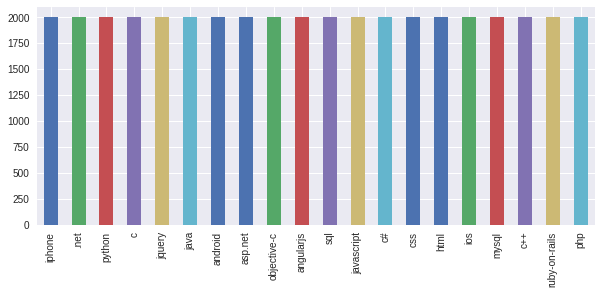

In [22]:
# defining our tags
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']

# visualising dataset
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

As you can see, the classes are very well balanced.

Now let's have a look at the post data in more detail: 

In [28]:
print(df['post'].values[1])

dynamic html load iframe aspnet 40 site users save entire html page backend database want load dynamic content div existing page content area couple things happen want css affect anything outside div first trying loading badly formed html would move images divs outside content area around lot html pages use base tag images links want base tag respected inside div solution going try use iframe set url another child page loads dynamic html page entirely wondering better solution


As you can see, the text needs to be cleaned up a bit. Below we use the nltk toolkit to remove spaces, stopwords, symbols etc. 

In [24]:
# note: slower students may wish to skip this step to finish the lab in class

import nltk
nltk.download('stopwords')
# !pip install lxml
import lxml

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     text = BeautifulSoup(text, features="xml").text
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df['post'] = df['post'].apply(clean_text)

In [29]:
print(df['post'].values[1])

dynamic html load iframe aspnet 40 site users save entire html page backend database want load dynamic content div existing page content area couple things happen want css affect anything outside div first trying loading badly formed html would move images divs outside content area around lot html pages use base tag images links want base tag respected inside div solution going try use iframe set url another child page loads dynamic html page entirely wondering better solution


This looks a lot better!

Now how many unique words do we have in this cleaned up dataset? 

In [30]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424194

Now we have over 3 million words to work with.

Before we start creating some classifiers, let's split our dataset in a test set (for evaluation) and training set: 

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Logistic regression

Now that we have our features, we can train a classifier to try to predict the tag of a post. We will start with logistic, which provides a nice baseline for this task. 

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [33]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7819166666666667
               precision    recall  f1-score   support

         java       0.70      0.62      0.66       613
         html       0.91      0.91      0.91       620
      asp.net       0.97      0.94      0.95       587
           c#       0.78      0.77      0.78       586
ruby-on-rails       0.77      0.81      0.79       599
       jquery       0.59      0.58      0.58       589
        mysql       0.77      0.75      0.76       594
          php       0.81      0.86      0.83       610
          ios       0.69      0.71      0.70       617
   javascript       0.61      0.59      0.60       587
       python       0.64      0.64      0.64       611
            c       0.82      0.83      0.83       594
          css       0.78      0.78      0.78       619
      android       0.84      0.85      0.84       574
       iphone       0.80      0.83      0.81       584
          sql       0.65      0.64      0.65       578
  objective-c       0.82      0.84  

That's quite a good accuracy. Now let's see if we can combine word2vec with logistic regression by feeding the new embedded representation to our logistic regression instead of the bag of words. 

### Word2vec embedding and Logistic Regression

Let's load a pretrained word2vec model, and use the embedding representation as input to a simple classifier (i.e. logistic regression). 

You can use the word2vec model you trained in lab 10a, or load this (quite big, 1.5GB) pretrained word2vec model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Note: it can take a while to load. (takes 2min for me) 

Alternatively, load from Dropbox to Colab again (skip this is you are not doing this):

In [40]:
# !pip install dropbox
import dropbox
access_token = 'your_token' # https://www.dropbox.com/developers/apps
dbx = dropbox.Dropbox(access_token)

j = "/yourpathindropbox/GoogleNews-vectors-negative300.bin.gz"
dbx.files_download_to_file('/GoogleNews-vectors-negative300.bin.gz', j)

FileMetadata(name='GoogleNews-vectors-negative300.bin.gz', id='id:F3kUIwrgEV8AAAAAAAtYbA', client_modified=datetime.datetime(2018, 10, 17, 9, 32, 40), server_modified=datetime.datetime(2018, 10, 22, 9, 24, 46), rev='69bcab5bbb0', size=1647046227, path_lower='/cds/week 10 - word2vec/lab/data/googlenews-vectors-negative300.bin.gz', path_display='/CDS/week 10 - word2vec/lab/data/GoogleNews-vectors-negative300.bin.gz', parent_shared_folder_id='3400907696', media_info=None, symlink_info=None, sharing_info=FileSharingInfo(read_only=False, parent_shared_folder_id='3400907696', modified_by='dbid:AACoui9q33n9Ww_K5AZehsrUdiK8zsU0_1E'), property_groups=None, has_explicit_shared_members=None, content_hash='75c1b5da05d0b4662d0631aba2dda7a7d9268a85da7bf057ecefbd905e21de1d')

Once the file is on your system: 

In [0]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('Model loaded')

If you are interested how good the embeddings are, you could try some of the similarity tests we did in Lab 10a. 

As we have multiple words for each post, we will need to somehow combine them, a common way is to average the
word vectors. This is a BOW approach (typically includes averaging, summation, weighted addition).

In [0]:
def word_averaging(wv, words):
    # averages a set of words 'words' given their wordvectors 'wv'
    
    all_words, mean = set(), []
    
    for word in words:
        # if the words are alread vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    
    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Below, we explore a different way to create tokens out of sentences, by using the nltk toolkit. 

In [0]:
import nltk.data
nltk.download('punkt')

def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

[nltk_data] Downloading package punkt to /Users/dorien/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's split the dataset in training and test set like before, and tokenize each of the datasets

In [0]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

We can then average the position per post in this new dataset using the functions we defined above and based on our word2vec model wv.

In [0]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':


Now we can feed this new representation into the logistic regression: 

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [0]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.637416666667
               precision    recall  f1-score   support

         java       0.62      0.59      0.61       613
         html       0.74      0.76      0.75       620
      asp.net       0.65      0.67      0.66       587
           c#       0.53      0.52      0.52       586
ruby-on-rails       0.70      0.77      0.73       599
       jquery       0.44      0.39      0.41       589
        mysql       0.65      0.60      0.63       594
          php       0.73      0.80      0.76       610
          ios       0.60      0.61      0.60       617
   javascript       0.56      0.52      0.54       587
       python       0.55      0.50      0.52       611
            c       0.61      0.61      0.61       594
          css       0.65      0.65      0.65       619
      android       0.61      0.57      0.59       574
       iphone       0.70      0.71      0.71       584
          sql       0.42      0.43      0.42       578
  objective-c       0.68      0.70      

Now you can see that the accuracy went down! Oh no! Why is that? Because we used a very naive approach, a BOW to average our vectors. The way around it would be doc2vec, which learns relationships between documents (posts in this case), instead of words.  

### Doc2vec and Logistic Regression (advanced, optional)

The idea of word2vec can be extended to documents where instead of learning feature representations for words, we learn it for sentences or documents. To get a general idea of a word2vec, think of it as a mathematical average of the word vector representations of all the words in the document. Doc2Vec extends the idea of word2vec, however words can only capture so much, there are times when we need relationships between documents and not just words.

The way to train doc2vec model for our Stack Overflow questions and tags data is very similar with when we train Multi-Class Text Classification with Doc2vec and Logistic Regression.

First, we label the sentences. Gensim’s Doc2Vec implementation requires each document/paragraph to have a label associated with it. We do this by using the TaggedDocument method. The format will be “TRAIN_i” or “TEST_i” where “i” is a dummy index of the post.

First let's import the necessary libraries. 


In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
from gensim.models import doc2vec

Let's start by defining a function that labels our sentences in the corpus. We just give them dummy labels TRAIN_i or TEST_i for post i. 

In [0]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

Just like above we split our dataset up in test and training data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

Let's have a look how our data looks at this moment: 

In [0]:
all_data[:2]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', '11', 'auto_increment', 'name', 'varchar', '150', 'lastname', 'varchar', '150', 'company', 'varchar', '250', 'adress', 'varchar', '150', 'postcode', 'int', '5', 'city', 'varchar', '150', 'email', 'varchar', '250', 'phone', 'varchar', '20', 'orgnr', 'varchar', '15', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name',

Gensim allows us to build a model very easily. We can vary the parameters to fit your data: 

*    dm=0 , distributed bag of words (DBOW) is used.
*    vector_size=300 , 300 vector dimensional feature vectors.
*    negative=5 , specifies how many “noise words” should be drawn.
*    min_count=1, ignores all words with total frequency lower than this.
*    alpha=0.065 , the initial learning rate.

We initialize the model and train for 30 epochs. (slower computers may want to train for less epochs)



In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 40000/40000 [00:00<00:00, 1448221.88it/s]


In [0]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 40000/40000 [00:00<00:00, 1987680.50it/s]


Now let's get the vectors out of this trained  model so that we can feed them into the logistic regression:

In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [0]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

We can now feed these vectors to the classifier again: 

In [0]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.80525
               precision    recall  f1-score   support

         java       0.71      0.66      0.68       589
         html       0.89      0.91      0.90       661
      asp.net       0.93      0.94      0.93       606
           c#       0.78      0.78      0.78       613
ruby-on-rails       0.84      0.90      0.87       601
       jquery       0.72      0.72      0.72       585
        mysql       0.87      0.82      0.84       621
          php       0.81      0.87      0.84       587
          ios       0.72      0.67      0.69       560
   javascript       0.66      0.65      0.66       611
       python       0.66      0.67      0.66       593
            c       0.81      0.83      0.82       581
          css       0.80      0.77      0.78       608
      android       0.84      0.85      0.85       593
       iphone       0.85      0.81      0.83       592
          sql       0.70      0.64      0.67       597
  objective-c       0.83      0.87      0.85   

80%, that is the best result so far! Remember, we can actually use any classifier with this method! So up to you to make your project as efficient as possible :)
    

## References

* https://radimrehurek.com/gensim/models/word2vec.html
* https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
* https://github.com/kavgan/nlp-text-mining-working-examples/tree/master/word2vec
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5